<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/7_deep_learning_parte2_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Segmentación de imágenes

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

In [ ]:
# Importamos todos los paquetes y módulos para entrenar el modelo

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

Google Colab nos ofrece poder utilizar GPUs (Graphical Processing Units) para realizar el entrenamiento. La utilización de este hardware nos facilita un entrenamiento muy significativamente más rápido que el entrenamiento en CPU.

In [ ]:
tf.test.gpu_device_name() # Verificamos que Tensorflow está utilizando una GPU

'/device:GPU:0'

## Clasificación Inception V3

In [ ]:
#Descargamos la Base de Datos, una versión mini de ImageNet
!gdown 1aNRd1WZT7s4vIXy3mGgLsMQI1N9B6qrc -O cats.zip

Downloading...
From: https://drive.google.com/uc?id=1aNRd1WZT7s4vIXy3mGgLsMQI1N9B6qrc
To: /content/cats.zip
100% 129M/129M [00:03<00:00, 33.0MB/s]


In [ ]:
#Unzip BD
!unzip -q cats.zip -d cats/

In [ ]:
from tensorflow.keras.applications import InceptionV3

#Base Model
pre_trained_model = InceptionV3(
    input_shape=(299, 299, 3), include_top=True, weights="imagenet")

#Base model por transfer
pre_trained_model_transfer = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet")

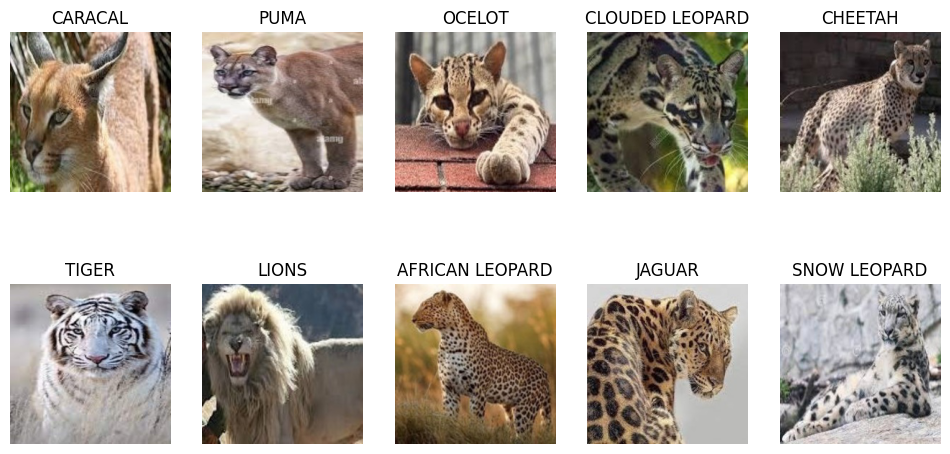

In [ ]:
from PIL import Image

img_size = (224, 224)

def plot_images(folder):
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, subfolder in enumerate(subfolders):
        filenames = os.listdir(subfolder)
        image_path = os.path.join(subfolder, filenames[4])
        image = Image.open(image_path)
        imgae = image.resize(img_size)
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(os.path.basename(subfolder))
        ax.axis("off")

plot_images("/content/cats/train")

In [ ]:
#Cargar Cats
#Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) # A las imágenes se les normaliza el brillo

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                shear_range = 0.2, # Distorsionamos las imágenes
                                                                zoom_range = 0.2, # Acercamos las imágenes
                                                                horizontal_flip = True,
                                                                vertical_flip=True) # Volteamos horizontalmente las imágenes

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

#Entrenamiento
train_cat = train_datagen.flow_from_directory('/content/cats/train',
                                              target_size = img_size, # Las imágenes se redimensionan a 64*64
                                              batch_size = 16,
                                              class_mode = 'categorical')

#Entrenamiento Data Augmentation
train_cat_aug = train_datagen_aug.flow_from_directory('/content/cats/train',
                                              target_size = img_size, # Las imágenes se redimensionan a 64*64
                                              batch_size = 16,
                                              class_mode = 'categorical')

#Validación
val_cat = test_datagen.flow_from_directory('/content/cats/valid',
                                              target_size = img_size, # Las imágenes se redimensionan a 64*64
                                              batch_size = 16,
                                              class_mode = 'categorical')

#Test
test_cat = test_datagen.flow_from_directory('/content/cats/test',
                                              target_size = img_size, # Las imágenes se redimensionan a 64*64
                                              batch_size = 16,
                                              class_mode = 'categorical')

Found 2339 images belonging to 10 classes.
Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
def get_callbacks(name_checkpoint='cats.hdf5.keras'):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint(name_checkpoint,verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [ ]:
#Flatten a una capa de 1 dimensión
x = layers.Flatten()(pre_trained_model_transfer.output)
#Se añade una capa Fully-Connected
x = layers.Dense(1024, activation="relu")(x)
#Se añade una capa de Dropout
x = layers.Dropout(0.2)(x)
#Capa final de clasificación
x = layers.Dense(10, activation="softmax")(x)

In [ ]:
model_1 = Model(pre_trained_model_transfer.input, x)

model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist_1 = model_1.fit(train_cat,
          epochs = 30,
          validation_data = val_cat,
          callbacks=get_callbacks(name_checkpoint='Model1cats.hdf5.keras'))

Epoch 1/30
147/147 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.1086
Epoch 1: val_loss improved from inf to 1473.03308, saving model to cats.hdf5
147/147 [==============================] - 78s 238ms/step - loss: 0.5731 - accuracy: 0.1086 - val_loss: 1473.0331 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 2/30
147/147 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.1124
Epoch 2: val_loss improved from 1473.03308 to 1.30200, saving model to cats.hdf5
147/147 [==============================] - 43s 296ms/step - loss: 0.3419 - accuracy: 0.1124 - val_loss: 1.3020 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 3/30
147/147 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.1411
Epoch 3: val_loss did not improve from 1.30200
147/147 [==============================] - 24s 163ms/step - loss: 0.3248 - accuracy: 0.1411 - val_loss: 27.3988 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 4/30
147/147 [==============================] - ETA: 0s 

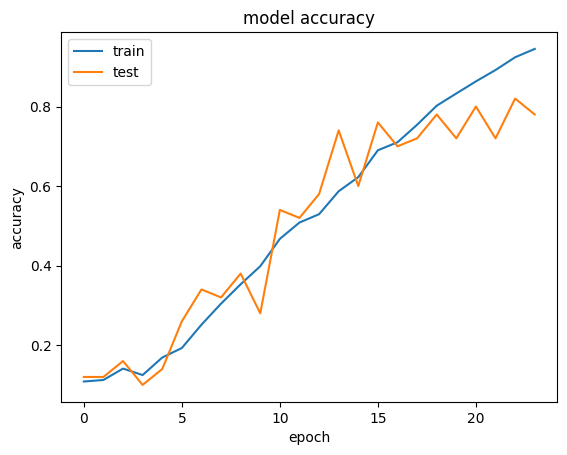

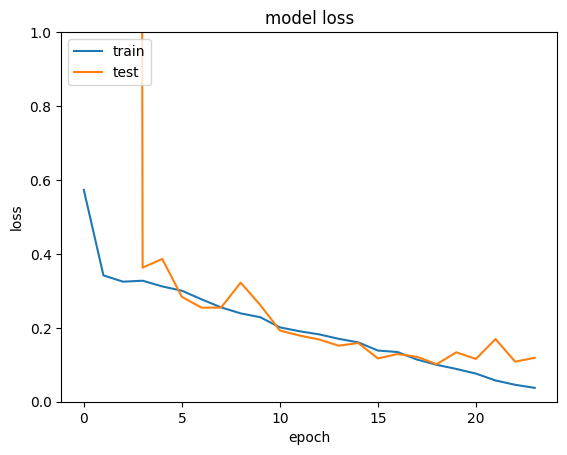

In [ ]:
# summarize history for accuracy
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim([0,1])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Actividad 1

Entrene nuevamente el modelo Inception V3 utilizando aumento de datos y compruebe la diferencia en el entrenamiento.

In [ ]:
#Prográmame

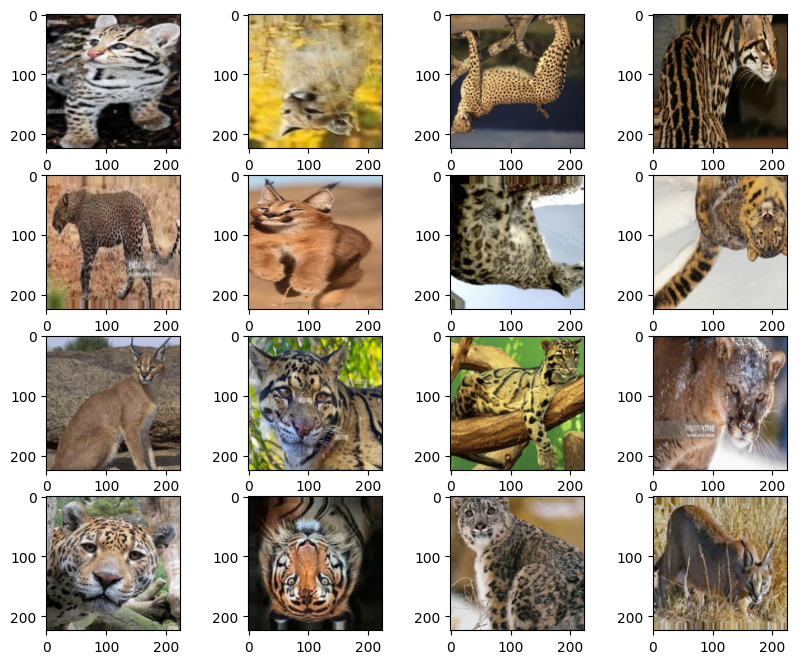

In [ ]:
#Observemos las imágenes con Data Augmentation

plt.figure(figsize=(10,8))
batch = next(train_cat_aug)
#Plots our figures
for i in range(1,17):
  plt.subplot(4, 4, i)
  image_ = batch[0][i-1,:,:,:]
  plt.imshow(image_)
plt.show()

## Segmentación con U-Net

In [ ]:
# Obtenemos el conjunto de datos de entrenamiento y prueba
!gdown 1M2dru41aniQR3fKXrNxd3cXfYd6J1Lvl -O stage1_test.zip
!gdown 1O7ZZvA2Co8PCi3XnLV71n0GUWx-5MmvR -O stage1_train.zip

In [ ]:
# Descomprimimos los conjuntos de datos.
!unzip -q stage1_train.zip -d stage1_train/
!unzip -q stage1_test.zip -d stage1_test/

In [ ]:
IMG_WIDTH = 128 # Ancho en el que se redimensionarán las imágenes.
IMG_HEIGHT = 128 # Alto en el que se redimensionarán las imágenes.
IMG_CHANNELS = 3 # Canales de color que tienen las imágenes (rojo, verde y azul)
TRAIN_PATH = 'stage1_train/' # Ubicación del conjunto de datos de entrenamiento.
TEST_PATH = 'stage1_test/' # Ubicación del conjunto de datos de prueba.

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Establecemos una semilla para la generación de datos aleatorios
seed = 11
random.seed = seed
np.random.seed = seed

In [ ]:
# Obtenemos los nombres de las imágenes de entrenamiento y prueba
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
# Redimensionamos todas las imágenes
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


<ipython-input-13-38464d2cb465>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-13-38464d2cb465>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 50.29it/s]

Done!


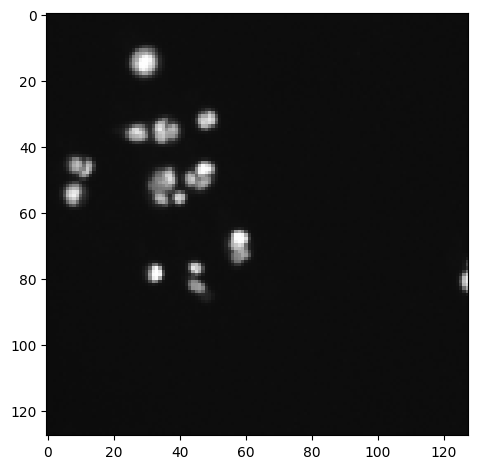

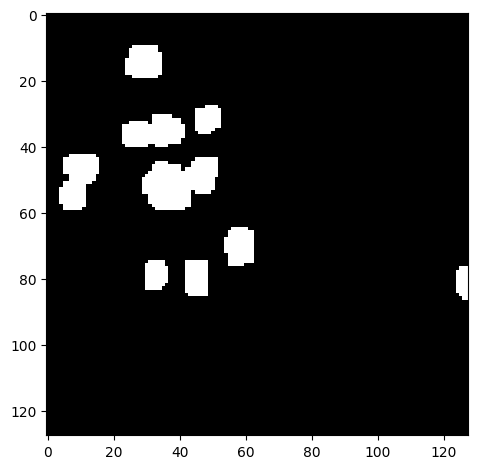

In [ ]:
# Verificamos la imagen cruda y la máscara de segmentación de una imagen al azar.
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

U-Net es una arquitectura especializada para la segmentación de imágenes biomédicas https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ .

Esta arquitectura utiliza una serie de capas de convolución para realizar las predicciones y el esquema es el siguiente:

![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# Esta es la implementación en TensorFlow de U-Net

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) # Capa convolucional
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

La arquitectura cuenta con alrededor de 2 millones de parámetros que serán entrenados.

In [ ]:
# Entrenamiento del modelo

earlystopper = EarlyStopping(patience=5, verbose=1)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,
                    callbacks=[earlystopper])

Epoch 1/50
38/38 [==============================] - 25s 120ms/step - loss: 0.4147 - mean_io_u: 0.3756 - val_loss: 0.2922 - val_mean_io_u: 0.3787
Epoch 2/50
38/38 [==============================] - 2s 49ms/step - loss: 0.2395 - mean_io_u: 0.3756 - val_loss: 0.2176 - val_mean_io_u: 0.3787
Epoch 3/50
38/38 [==============================] - 2s 49ms/step - loss: 0.1902 - mean_io_u: 0.3756 - val_loss: 0.9401 - val_mean_io_u: 0.3787
Epoch 4/50
38/38 [==============================] - 2s 49ms/step - loss: 0.1594 - mean_io_u: 0.3756 - val_loss: 0.2020 - val_mean_io_u: 0.3787
Epoch 5/50
38/38 [==============================] - 2s 53ms/step - loss: 0.1581 - mean_io_u: 0.3756 - val_loss: 0.7223 - val_mean_io_u: 0.3787
Epoch 6/50
38/38 [==============================] - 2s 49ms/step - loss: 0.1431 - mean_io_u: 0.3756 - val_loss: 0.1498 - val_mean_io_u: 0.3787
Epoch 7/50
38/38 [==============================] - 2s 50ms/step - loss: 0.1375 - mean_io_u: 0.3756 - val_loss: 0.1773 - val_mean_io_u: 0.37

In [ ]:
# Predicción sobre los datos de entrenamiento, validación y prueba

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 202ms/step


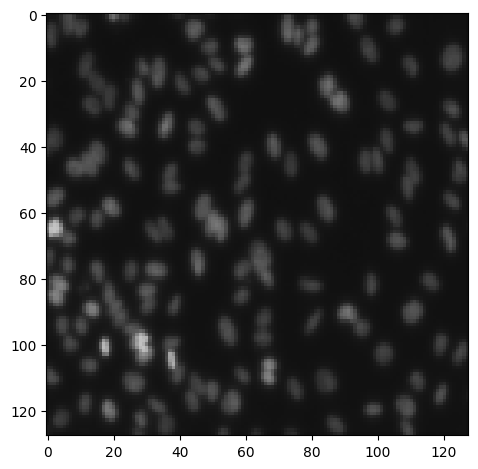

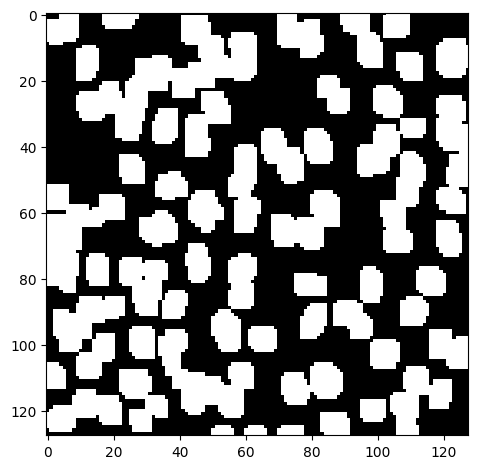

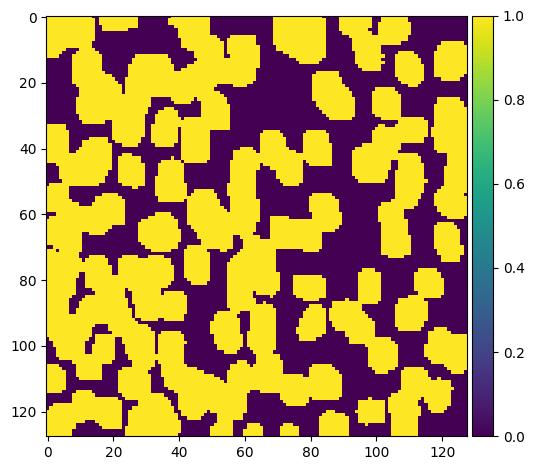

In [ ]:
# Visualizamos unas predicciones al azar sobre el conjunto de entrenamiento

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

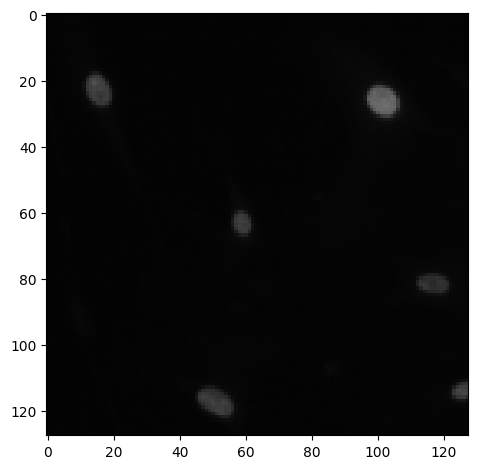

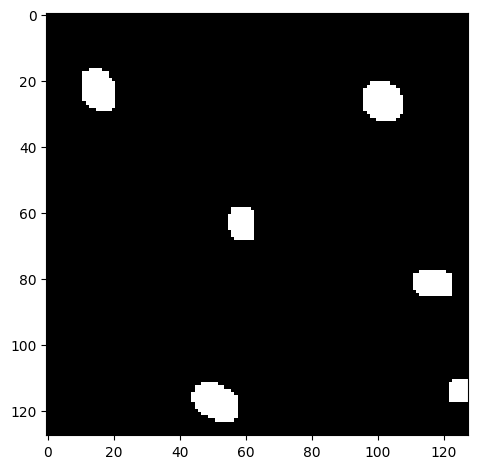

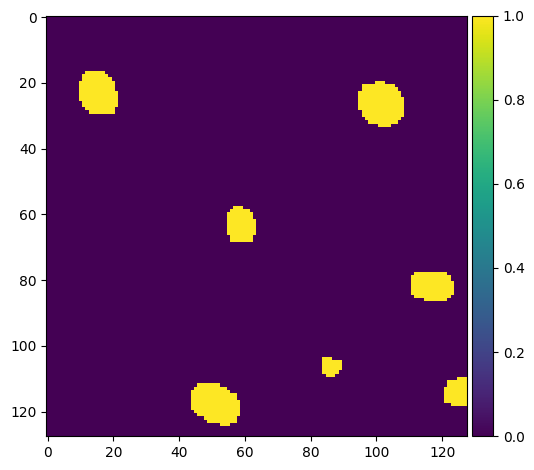

In [ ]:
# Visualizamos unas predicciones al azar sobre el conjunto de validación

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


## Actividad 2

Visualiza la salida de la según fase de convoluciones en downscaling (c2) y la penúltima capa de upscaling (c8). Puedes utilizar las funciones de la clase anterior.

In [ ]:
# Prográmame!
img = X_train[0]

if img.ndim == 3:
  img = np.expand_dims(img, axis=0)